In [2]:
Sys.setenv(PATH = paste("C:/RBuildTools/Rtools/mingw_64/bin/", Sys.getenv("PATH"), sep=";"))
Sys.setenv(BINPREF = "C:/RBuildTools/Rtools/mingw_64/bin/")

# library(rstanarm)
library(lme4)
library(ggplot2)
library(scales)
library(shinystan)
library(lubridate)
library(brms)
library(tidyverse)
#library(parallel)
library(devtools)

#Sys.setenv("MC_CORES"= 8)
#Sys.getenv("MC_CORES")
Sys.which("g++")

Warning message:
"package 'lme4' was built under R version 3.6.2"
Loading required package: Matrix

Warning message:
"package 'ggplot2' was built under R version 3.6.2"
Warning message:
"package 'scales' was built under R version 3.6.2"
Warning message:
"package 'shinystan' was built under R version 3.6.2"
Loading required package: shiny

Warning message:
"package 'shiny' was built under R version 3.6.2"

This is shinystan version 2.5.0


Warning message:
"package 'lubridate' was built under R version 3.6.2"

Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date


Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 3.6.2"
Loading 'brms' package (version 2.11.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:lme4':

    ngrps


Warni

g++ 
"C:\\RBUILD~1\\Rtools\\mingw_64\\bin\\G__~1.EXE"

In [3]:
# .libPaths("C:/Program Files/R/R-3.6.2/library")

In [4]:
data = read.csv("data_co2_occ_num_filtered_30.csv")

colnames(data)[colnames(data) == 'sensor_name'] <- 'room'

summary(data)

                         X          occupancy          room    
 2019-11-20 08:00:00+00:00:   5   Min.   :0.0000   ROOM 1:306  
 2019-11-20 08:30:00+00:00:   5   1st Qu.:0.0000   ROOM 2:301  
 2019-11-20 09:00:00+00:00:   5   Median :0.0000   ROOM 3:277  
 2019-11-20 09:30:00+00:00:   5   Mean   :0.6497   ROOM 4:312  
 2019-11-20 10:00:00+00:00:   5   3rd Qu.:1.0000   ROOM 5:317  
 2019-11-21 08:00:00+00:00:   5   Max.   :9.0000               
 (Other)                  :1483                                
      co2             noise          humidity      temperature   
 Min.   : 400.2   Min.   :47.28   Min.   :30.98   Min.   :20.95  
 1st Qu.: 509.4   1st Qu.:51.52   1st Qu.:36.62   1st Qu.:21.79  
 Median : 577.5   Median :54.03   Median :39.78   Median :22.09  
 Mean   : 645.1   Mean   :54.65   Mean   :40.05   Mean   :22.23  
 3rd Qu.: 699.4   3rd Qu.:57.42   3rd Qu.:43.46   3rd Qu.:22.58  
 Max.   :2426.6   Max.   :69.89   Max.   :51.36   Max.   :24.72  
                          

Data rescaling and adding new categorical variables (to be used later)

In [5]:
data$co2.rescaled <- rescale(data$co2) 

data$day_of_week <- factor(weekdays(as.Date(data$X)))

data$time<-format(strptime(data$X, "%Y-%m-%d %H:%M:%S"), "%H:%M:%S")

weekdays <- c('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')

breaks <- hour(hm("00:00", "6:00", "11:00", "14:00", "17:00", "23:59"))

labels <- c("Night", "Morning", "Afternoon","Late afternoon", "Evening")

data$weekday <- factor((weekdays(as.Date(data$X)) %in% weekdays), levels=c(FALSE, TRUE), labels=c('weekend', 'weekday'))

data$time_cat <- cut(x=hour(data$X), breaks = breaks, labels = labels, include.lowest=TRUE)

In [6]:
head(data)

,X,occupancy,room,co2,noise,humidity,temperature,co2.rescaled,day_of_week,time,weekday,time_cat
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>,<fct>
1,2019-11-20 08:00:00+00:00,0,ROOM 1,480.8556,50.85000,35.45825,21.30693,0.03982279,Wednesday,08:00:00,weekday,Morning
2,2019-11-20 08:30:00+00:00,0,ROOM 1,511.2000,52.91812,35.54536,21.45572,0.05479677,Wednesday,08:30:00,weekday,Morning
3,2019-11-20 09:00:00+00:00,0,ROOM 1,540.2248,53.10444,35.66022,21.72000,0.06911954,Wednesday,09:00:00,weekday,Morning
4,2019-11-20 09:30:00+00:00,0,ROOM 1,540.9333,55.15111,37.14889,21.72300,0.06946919,Wednesday,09:30:00,weekday,Morning
5,2019-11-20 10:00:00+00:00,2,ROOM 1,679.3540,50.02222,36.48111,21.54056,0.13777524,Wednesday,10:00:00,weekday,Morning
6,2019-11-20 10:30:00+00:00,2,ROOM 1,741.8699,50.43556,35.96489,21.81178,0.16862474,Wednesday,10:30:00,weekday,Morning


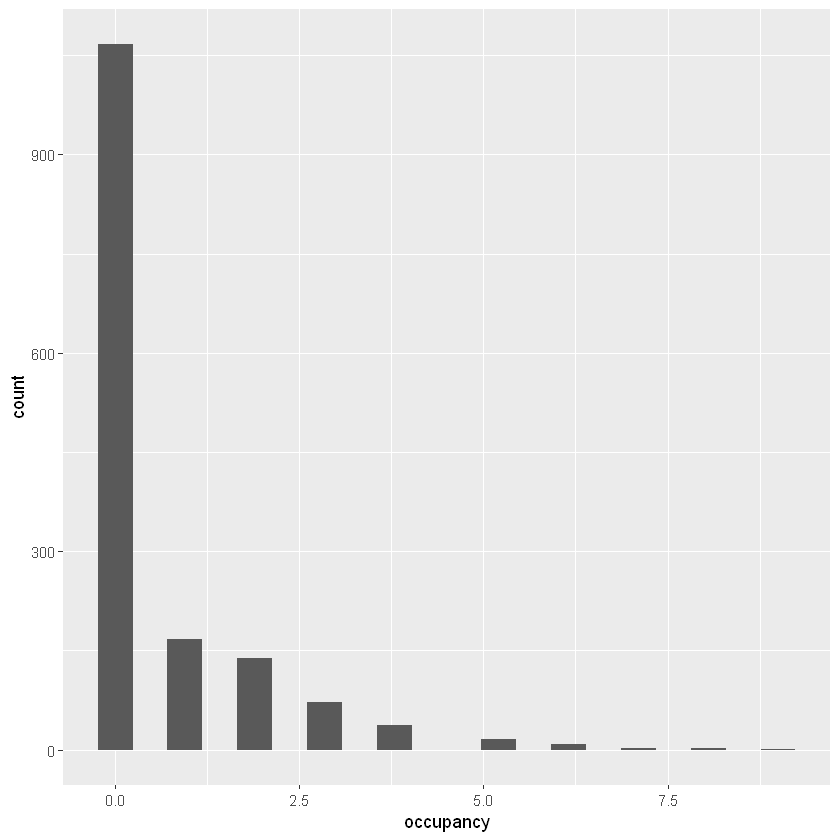

In [6]:
ggplot(data, aes(x = occupancy)) + geom_histogram(bins=20)

In [7]:
model_num1 <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room), data = data, family=poisson)

summary(model_num1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  3061.7   3077.7  -1527.8   3055.7     1510 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8759 -0.6826 -0.5893  0.4459  5.8866 

Random effects:
 Groups Name        Variance Std.Dev.
 room   (Intercept) 0.05292  0.23    
Number of obs: 1513, groups:  room, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.2441     0.1140  -10.91   <2e-16 ***
co2.rescaled   4.6107     0.1606   28.70   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.314

In [9]:
model_num2 <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week), data = data, family=poisson)

summary(model_num2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  2984.3   3005.6  -1488.1   2976.3     1509 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9467 -0.6857 -0.5659  0.3002  6.9301 

Random effects:
 Groups      Name        Variance Std.Dev.
 room        (Intercept) 0.06279  0.2506  
 day_of_week (Intercept) 0.13578  0.3685  
Number of obs: 1513, groups:  room, 5; day_of_week, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.2785     0.2056  -6.218 5.02e-10 ***
co2.rescaled   4.5803     0.1641  27.907  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.177

In [10]:
model_num3 <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) + (1 | time_cat) , data = data, family=poisson)

summary(model_num3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) +  
    (1 | time_cat)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  2931.5   2958.1  -1460.8   2921.5     1508 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8469 -0.6972 -0.5249  0.2381 13.2959 

Random effects:
 Groups      Name        Variance Std.Dev.
 room        (Intercept) 0.06246  0.2499  
 day_of_week (Intercept) 0.14700  0.3834  
 time_cat    (Intercept) 0.35637  0.5970  
Number of obs: 1513, groups:  room, 5; day_of_week, 5; time_cat, 4

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.5040     0.3682  -4.085 4.41e-05 ***
co2.rescaled   4.4221     0.1749  25.289  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.089

In [7]:
data_binary = read.csv("data_co2_occ_bin_filtered_30.csv")

colnames(data_binary)[colnames(data_binary) == 'sensor_name'] <- 'room'

In [8]:
head(data_binary)

,X,occupancy,room,co2,noise,humidity,temperature
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-11-20 08:00:00+00:00,0,ROOM 1,480.8556,50.85000,35.45825,21.30693
2,2019-11-20 08:30:00+00:00,0,ROOM 1,511.2000,52.91812,35.54536,21.45572
3,2019-11-20 09:00:00+00:00,1,ROOM 1,540.2248,53.10444,35.66022,21.72000
4,2019-11-20 09:30:00+00:00,1,ROOM 1,540.9333,55.15111,37.14889,21.72300
5,2019-11-20 10:00:00+00:00,0,ROOM 1,679.3540,50.02222,36.48111,21.54056
6,2019-11-20 10:30:00+00:00,1,ROOM 1,741.8699,50.43556,35.96489,21.81178


In [9]:
data_binary$co2.rescaled <- rescale(data_binary$co2) 

data_binary$day_of_week <- factor(weekdays(as.Date(data_binary$X)))

data_binary$time_cat <- cut(x=hour(data_binary$X), breaks = breaks, labels = labels, include.lowest=TRUE)

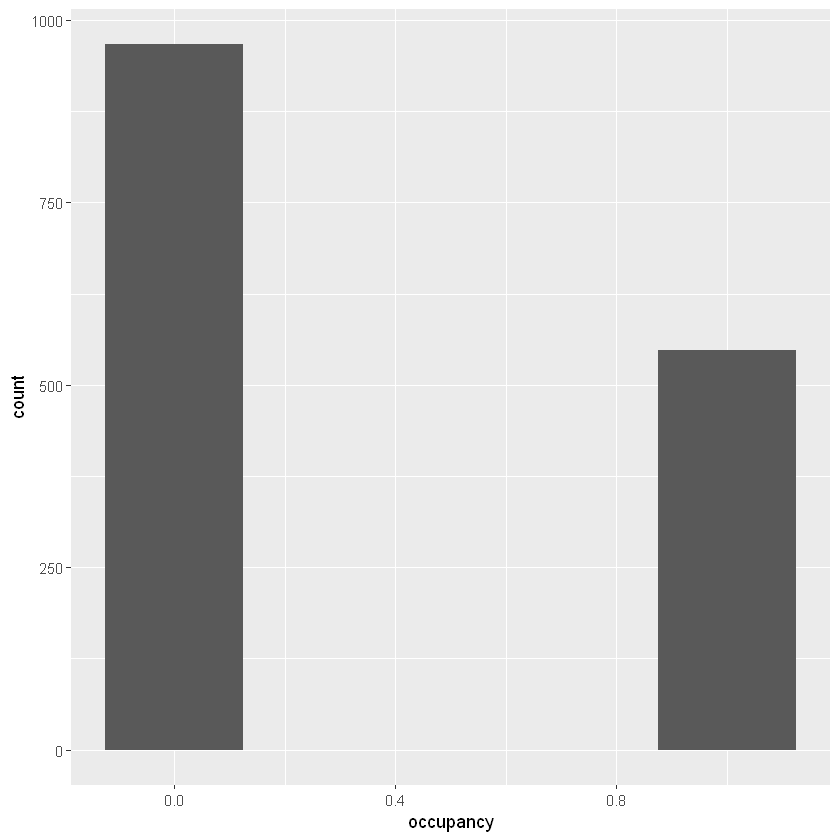

In [8]:
ggplot(data_binary, aes(x = occupancy)) + geom_histogram(bins=5)

In [9]:
model_bin <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room), data = data_binary, family=binomial(link = "logit"))

summary(model_bin)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room)
   Data: data_binary

     AIC      BIC   logLik deviance df.resid 
  1950.1   1966.1   -972.1   1944.1     1511 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3135 -0.7381 -0.6506  1.2171  1.7537 

Random effects:
 Groups Name        Variance Std.Dev.
 room   (Intercept) 0.04622  0.215   
Number of obs: 1514, groups:  room, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.9314     0.1282  -7.263 3.80e-13 ***
co2.rescaled   2.8579     0.5133   5.568 2.58e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.507

In [10]:
model_bin2 <- glmer(occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) + (1 | time_cat), data = data_binary, family=binomial(link = "logit"))

summary(model_bin2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) +  
    (1 | time_cat)
   Data: data_binary

     AIC      BIC   logLik deviance df.resid 
  1734.9   1761.5   -862.4   1724.9     1509 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9495 -0.7903 -0.4375  0.9551 10.3122 

Random effects:
 Groups      Name        Variance Std.Dev.
 room        (Intercept) 0.06031  0.2456  
 day_of_week (Intercept) 0.09031  0.3005  
 time_cat    (Intercept) 4.05698  2.0142  
Number of obs: 1514, groups:  room, 5; day_of_week, 5; time_cat, 4

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.7593     1.0439  -1.685 0.091937 .  
co2.rescaled   2.0771     0.5625   3.693 0.000222 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
co2.rescald -0.0

# Hierarchical Model Equation

We introduce $i$ observations, $j$ groups

$\beta _{0j}$ and $\beta_{1j}$ are the intercept and slope (respectively) of the dependent variable in group $j$. Components $CO_2$ and $\epsilon_{ij}$ and predictor and error term, respectively.

First level:

$$ occupancy_{ij} = \beta_{0j} + \beta_{1j} \cdot CO_2 + \epsilon_{ij} $$

Second level:

$\gamma_{00}$ is the intercept and $\gamma_{10}$ is the slope, between the dependent variable and the Level 1 predictor. 
Components $u_{0j}$ and $u_{1j}$ are errors of intercept and slope.

Intercept:
$$\beta_{0j} = \gamma_{00} + u_{0j} $$

Slope:
$$ \beta_{1j} = \gamma_{10} + u_{1j} $$


## Poisson Regression

#### Occupancy measured in the number of people present

In [11]:
model_num_poiss_fixed <- brm(data = data, family = poisson,
                         occupancy ~ 1 + co2.rescaled,
                         iter = 2000, cores = 8, seed = 334)

Compiling the C++ model

Start sampling



In [12]:
summary(model_num_poiss_fixed)

 Family: poisson 
  Links: mu = log 
Formula: occupancy ~ 1 + co2.rescaled 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.18      0.05    -1.27    -1.09 1.00     1415     1609
co2.rescaled     4.31      0.12     4.08     4.54 1.00     1586     2215

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

In [14]:
bayes_R2(model_num_poiss_fixed)

,Estimate,Est.Error,Q2.5,Q97.5
R2,0.4393977,0.02135887,0.395172,0.4780811


In [15]:
model_num_poiss <- brm(data = data, family = poisson,
                         occupancy ~ 1 + co2.rescaled + (1 | room),
                         iter = 3000, cores = 8, seed = 334,
                         control = list(adapt_delta = 0.999999999, max_treedepth=20))

Compiling the C++ model

Start sampling



In [16]:
summary(model_num_poiss)

 Family: poisson 
  Links: mu = log 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 3000; warmup = 1500; thin = 1;
         total post-warmup samples = 6000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.43      0.31     0.16     1.22 1.00      918     1152

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -1.25      0.24    -1.71    -0.79 1.00     1156     1134
co2.rescaled     4.63      0.16     4.30     4.95 1.00     2781     2354

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

In [17]:
bayes_R2(model_num_poiss)

,Estimate,Est.Error,Q2.5,Q97.5
R2,0.4479431,0.02045627,0.4042643,0.4830147


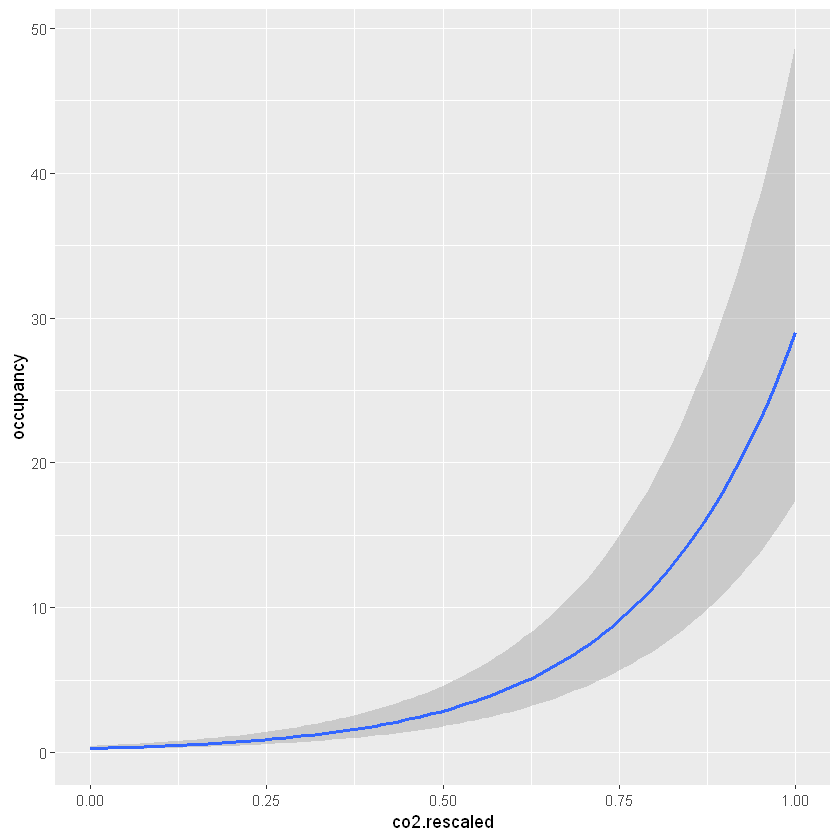

In [18]:
plot(conditional_effects(model_num_poiss), ask = FALSE)

In [19]:
model_num_posterior_prob_pois <- posterior_interval(model_num_poiss,
                                            prob = 0.95)
round(model_num_posterior_prob_pois, 2)

,2.5%,97.5%
b_Intercept,-1.71,-0.79
b_co2.rescaled,4.30,4.95
sd_room__Intercept,0.16,1.22
Intercept,-1.15,-0.24
"r_room[ROOM.1,Intercept]",-0.84,0.11
"r_room[ROOM.2,Intercept]",-0.31,0.63
"r_room[ROOM.3,Intercept]",-0.66,0.29
"r_room[ROOM.4,Intercept]",-0.14,0.78
"r_room[ROOM.5,Intercept]",-0.38,0.56
lp__,-1541.70,-1531.83


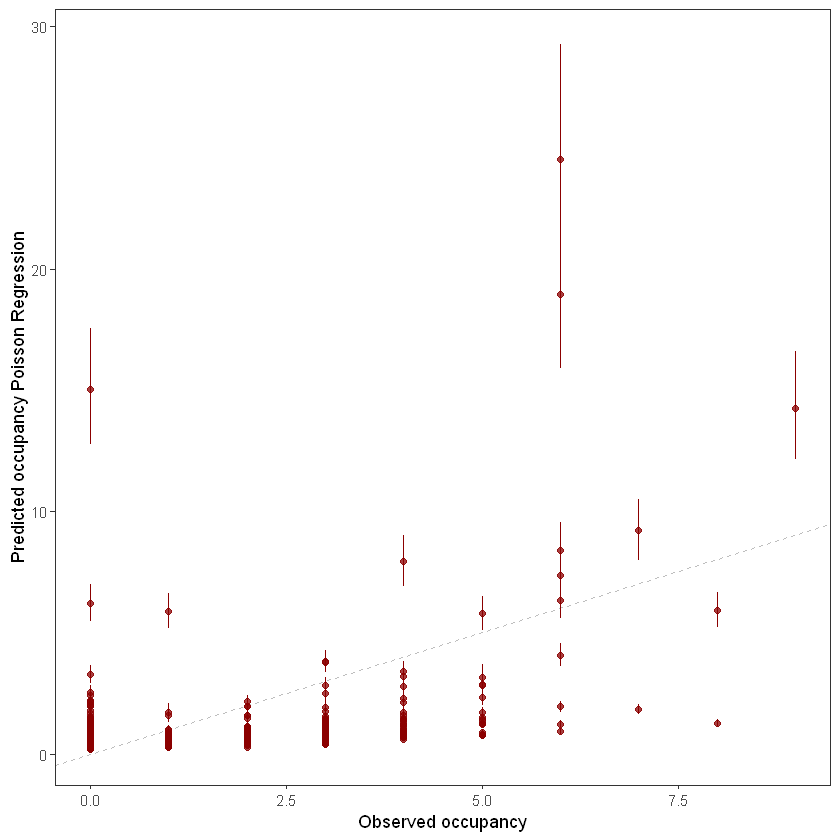

In [20]:
fitted(model_num_poiss) %>%
  as_tibble() %>%
  bind_cols(data)  %>%
  
  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Poisson Regression") +
  theme_bw() +
  theme(panel.grid = element_blank())

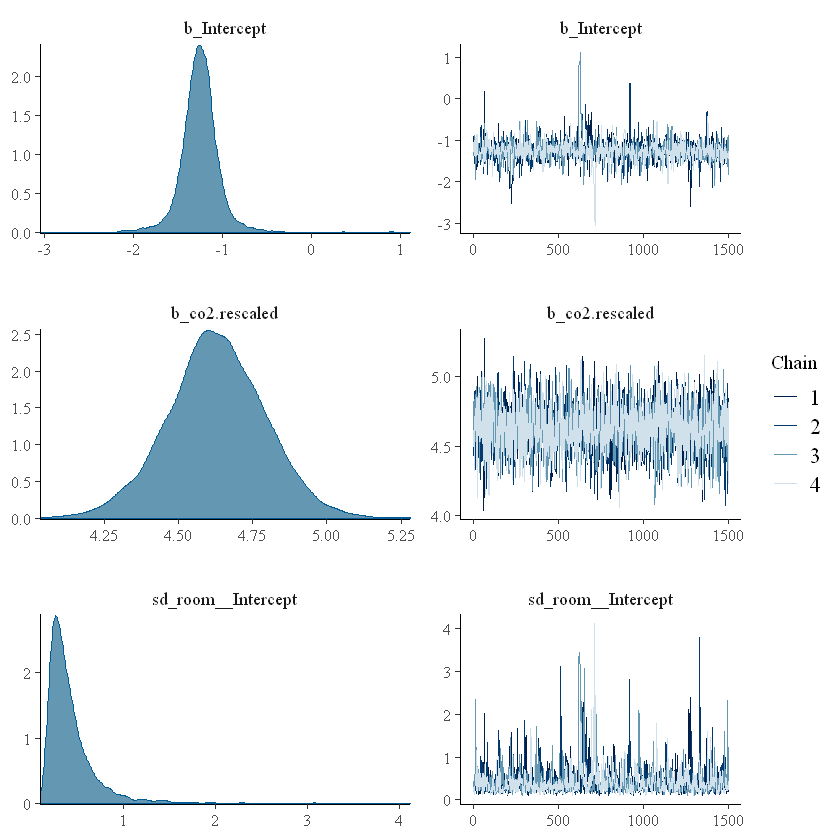

In [21]:
plot(model_num_poiss)

In [22]:
post_model_num_poiss <- posterior_samples(model_num_poiss, add_chain = T)
head(post_model_num_poiss)

,b_Intercept,b_co2.rescaled,sd_room__Intercept,Intercept,"r_room[ROOM.1,Intercept]","r_room[ROOM.2,Intercept]","r_room[ROOM.3,Intercept]","r_room[ROOM.4,Intercept]","r_room[ROOM.5,Intercept]",lp__,chain,iter
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,-0.9142059,4.486288,0.2744337,-0.3720478,-0.6515344,-0.11840732,-0.38465762,0.03096202,-0.08795909,-1538.306,1,1501
2,-1.2085440,4.636265,0.2088201,-0.6482616,-0.4366133,-0.03051875,-0.22271318,0.17509403,-0.08266475,-1538.668,1,1502
3,-1.2092937,4.496645,0.3010531,-0.6658841,-0.2328863,0.16915885,-0.12640543,0.21662176,0.12068993,-1535.094,1,1503
4,-1.1123149,4.595865,0.4015808,-0.5569147,-0.3769834,-0.04240981,-0.28647934,0.20101806,-0.11481637,-1533.293,1,1504
5,-1.0910385,4.512530,0.4583401,-0.5457092,-0.3782940,0.01034474,-0.31447344,0.21725005,-0.24621642,-1536.091,1,1505
6,-1.3145845,4.579677,0.2378417,-0.7611406,-0.2118658,0.19016304,-0.07544458,0.33874403,0.11698854,-1534.285,1,1506


## Occupancy measured in binary terms: ocuppied / not occupied

In [19]:
model_bin_logit <- brm(data = data_binary, family = bernoulli(link = "logit"),
                         occupancy ~ 1 + co2.rescaled + (1 | room),
                         iter = 2000, cores = 8, seed = 334,
                         control = list(adapt_delta = 0.9999999, max_treedepth=20))

Compiling the C++ model

Start sampling



In [20]:
summary(model_bin_logit)

 Family: bernoulli 
  Links: mu = logit 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data_binary (Number of observations: 1514) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.39      0.28     0.12     1.13 1.00      703      835

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.92      0.23    -1.32    -0.40 1.01      895      695
co2.rescaled     2.95      0.51     1.96     3.97 1.00     2298     2268

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

In [21]:
bayes_R2(model_bin_logit)

,Estimate,Est.Error,Q2.5,Q97.5
R2,0.03196991,0.008461697,0.01638982,0.04962713


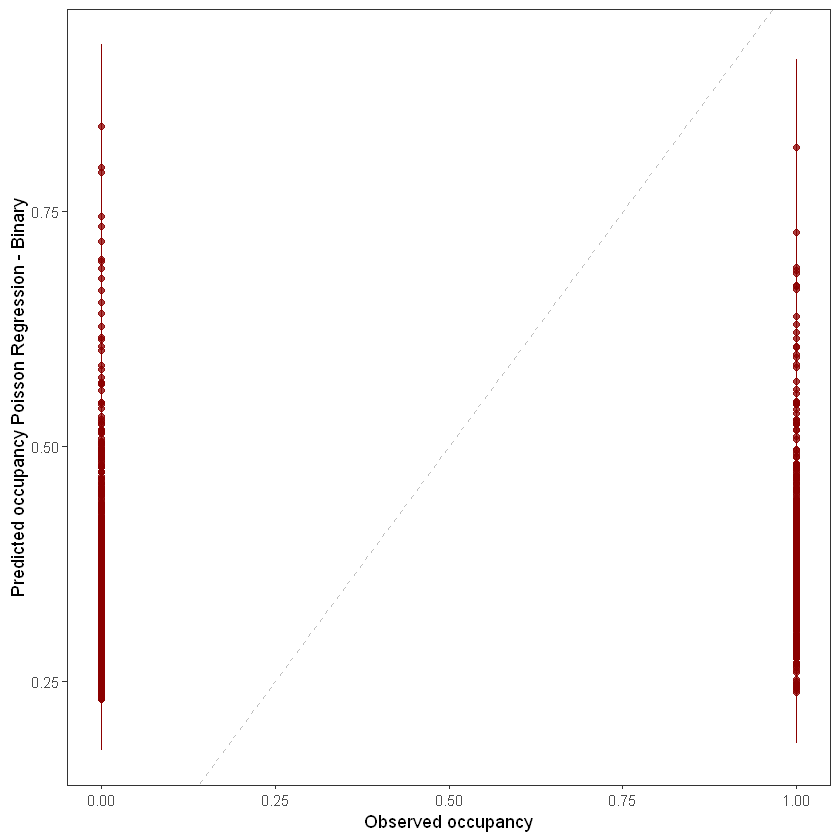

In [22]:
fitted(model_bin_logit) %>%
  as_tibble() %>%
  bind_cols(data_binary)  %>%
  
  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Poisson Regression - Binary") +
  theme_bw() +
  theme(panel.grid = element_blank())

In [ ]:
model_bin_logit2 <- brm(data = data_binary, family = bernoulli(link = "logit"),
                         occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week),
                         iter = 2000, cores = 1, seed = 334,
                         control = list(adapt_delta = 0.9999999, max_treedepth=20))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [ ]:
bayes_R2(model_bin_logit2)

In [15]:
model_bin_logit3 <- brm(data = data_binary, family = bernoulli(link = "logit"),
                         occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) + (1 | time_cat),
                         iter = 2000, cores = 1, seed = 334,
                         control = list(adapt_delta = 0.9999999, max_treedepth=20))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '7f63750d998f168f9be8907318dcc215' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 189.404 seconds (Warm-up)
Chain 1:                650.896 seconds (Sampling)
Chain 

In [16]:
bayes_R2(model_bin_logit3)

,Estimate,Est.Error,Q2.5,Q97.5
R2,0.1590637,0.01253012,0.1342054,0.1832477


In [ ]:
plot(model_bin_logit)

In [ ]:
loo_model_num_poiss <- loo(model_bin_logit, k_threshold = 0.7, reloo = TRUE, cores = getOption("mc.cores", 1))
loo_model_bin_logit2 <- loo(model_bin_logit2, k_threshold = 0.7, cores = getOption("mc.cores", 1))
loo_model_bin_logit3 <-loo(model_bin_logit3, k_threshold = 0.7, cores = getOption("mc.cores", 1))

loo_compare(loo_model_num_poiss, loo_model_bin_logit2, loo_model_bin_logit3)

# Negative Binomial Regression
#### Occupancy measured in the number of people present

In [107]:
model_num_negbinomial <- brm(data = data, family = negbinomial,
                       occupancy ~ 1 + co2.rescaled + (1 | room), iter = 2000,
                       cores = 8, control = list(adapt_delta = 0.99999999, max_treedepth=20), seed = 334)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [ ]:
model_num_negbinomial_c <- brm(data = data, family = negbinomial,
                       occupancy ~ 1 + co2 + (1 | room), iter = 2000,
                       cores = 8, control = list(adapt_delta = 0.99999999, max_treedepth=20), seed = 334)

In [ ]:
summary(model_num_negbinomial_c)

In [108]:
summary(model_num_negbinomial)

 Family: negbinomial 
  Links: mu = log; shape = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.55      0.41     0.19     1.61 1.01      676      937

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -2.07      0.33    -2.67    -1.43 1.00      926     1096
co2.rescaled     9.45      0.59     8.34    10.67 1.00     2205     1951

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     0.88      0.10     0.71     1.09 1.00     2267     2152

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rh

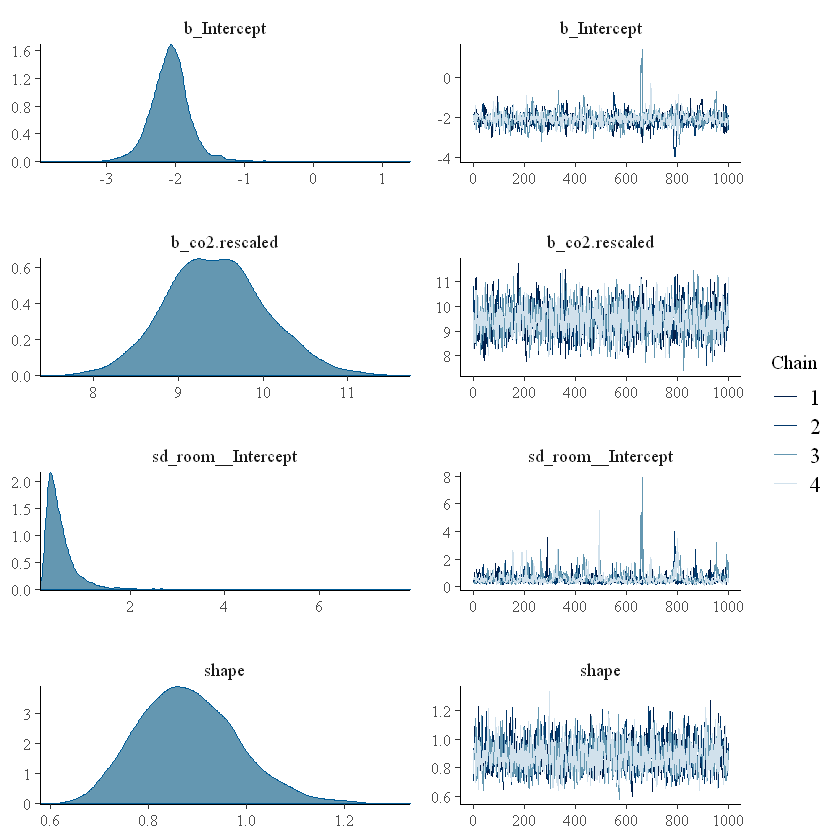

In [109]:
plot(model_num_negbinomial)

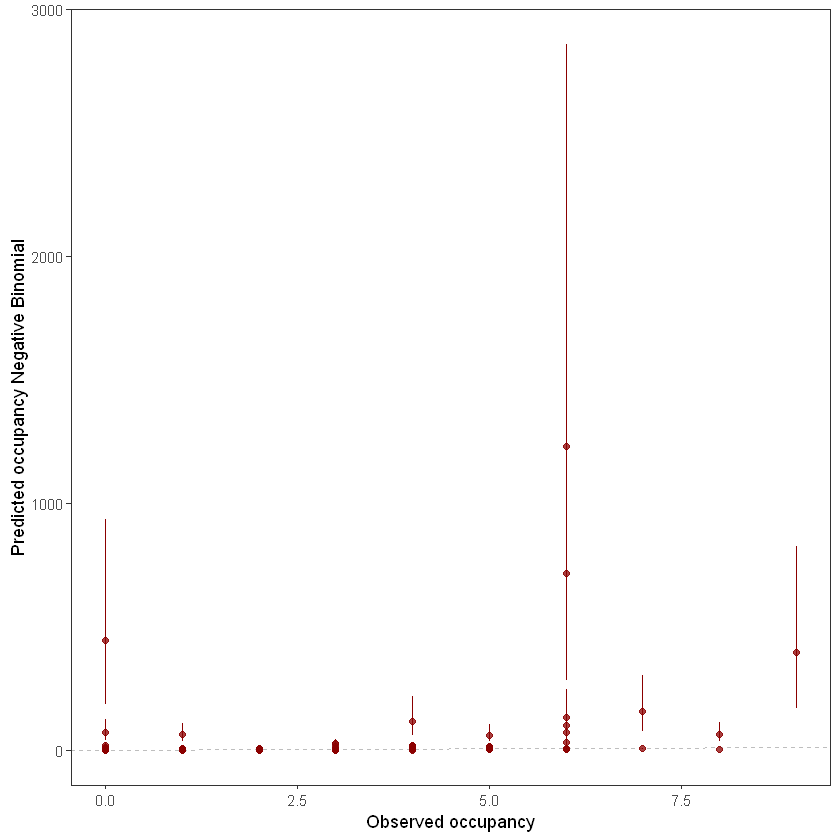

In [110]:
fitted(model_num_negbinomial) %>%
  as_tibble() %>%
  bind_cols(data)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Negative Binomial") +
  theme_bw() +
  theme(panel.grid = element_blank())

## Zero Inflated Poisson model
#### Occupancy measured in the number of people present

In [88]:
model_num_zero_inflated_poisson <- brm(data = data, family = zero_inflated_poisson,
                                       occupancy ~ 1 + co2.rescaled + (1 | room), iter = 3000,
                                       cores = 8, control = list(adapt_delta = 0.9999999), seed = 334)

Compiling the C++ model

Start sampling



In [ ]:
model_num_zero_inflated_poisson_c <- brm(data = data, family = zero_inflated_poisson,
                                       occupancy ~ 1 + co2 + (1 | room), iter = 3000,
                                       cores = 8, control = list(adapt_delta = 0.9999999), seed = 334)

In [ ]:
summary(model_num_zero_inflated_poisson_c)

In [89]:
summary(model_num_zero_inflated_poisson)

 Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) 
   Data: data (Number of observations: 1513) 
Samples: 4 chains, each with iter = 3000; warmup = 1500; thin = 1;
         total post-warmup samples = 6000

Group-Level Effects: 
~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.40      0.24     0.15     1.03 1.00     1310     2172

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.48      0.21    -0.90    -0.05 1.00     1521     1973
co2.rescaled     3.67      0.21     3.26     4.09 1.00     2776     3384

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.49      0.03     0.43     0.54 1.00     3331     3421

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and R

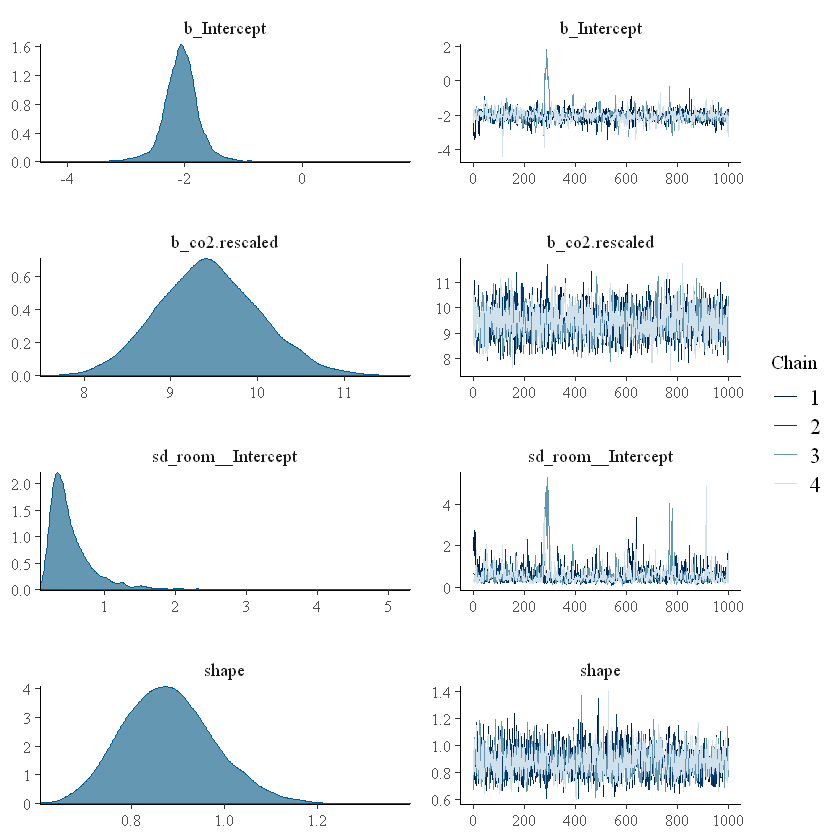

In [91]:
plot(model_num_negbinomial)

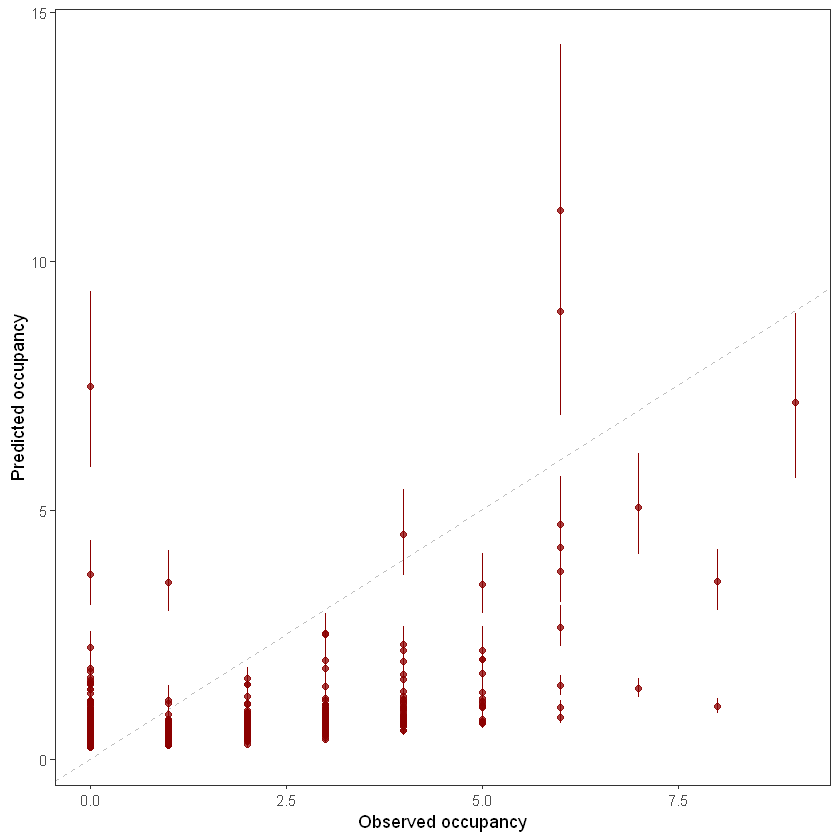

In [90]:
fitted(model_num_zero_inflated_poisson) %>%
  as_tibble() %>%
  bind_cols(data)  %>%

  ggplot(aes(x = occupancy, y = Estimate)) +
  geom_abline(linetype = 2, color = "grey", size = .5) +
  geom_point(size = 1.5, color = "darkred", alpha = 3/4) +
  geom_linerange(aes(ymin = Q2.5, ymax = Q97.5),
                 size = 1/4, color = "darkred") +
  geom_linerange(aes(ymin = Estimate - Est.Error, 
                     ymax = Estimate + Est.Error),
                 size = 1/2, color = "darkred") +
  labs(x = "Observed occupancy", 
       y = "Predicted occupancy Zero Inflated Poisson") +
  theme_bw() +
  theme(panel.grid = element_blank())

## Adding day of the week as a covariate

In [ ]:
model_num_zero_inflated_poisson_day <- brm(data = data, family = zero_inflated_poisson,
                                           occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week), iter = 1000,
                                           cores = 1, control = list(adapt_delta = 0.9999999), seed = 334)

#### Output produced in RStudio

```
Family: zero_inflated_poisson 
  Links: mu = log; zi = identity 
Formula: occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) 
   Data: data (Number of observations: 6449) 
Samples: 4 chains, each with iter = 3000; warmup = 1500; thin = 1;
         total post-warmup samples = 6000

Group-Level Effects: 
~day_of_week (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.31      0.20     0.12     0.82 1.00     1491     2717

~room (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.48      0.32     0.19     1.32 1.00     1424     2216

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -0.76      0.29    -1.33    -0.18 1.00     2284     2322
co2.rescaled     4.60      0.14     4.32     4.89 1.00     4526     4306

Family Specific Parameters: 
   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
zi     0.68      0.01     0.65     0.71 1.00     4666     3624

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).
```
<img src="Rplot_zero_inf_pois_day.jpeg" height="800" width="600">


## Adding day of the week and time of the day as a covariate

In [ ]:
model_num_zero_inflated_poisson_time <- brm(data = data, family = zero_inflated_poisson,
                                            occupancy ~ 1 + co2.rescaled + (1 | room) + (1 | day_of_week) + (1 | time_cat),
                                            iter = 3000, cores = 1, control = list(adapt_delta = 0.9), seed = 334)

## Leave-one-out cross-validation 
#### Occupancy measured in the number of people present

In [117]:
loo_model_num_poiss <- loo(model_num_poiss, k_threshold = 0.7, reloo = TRUE, cores = getOption("mc.cores", 1))
loo_model_num_negbinomial <- loo(model_num_negbinomial, k_threshold = 0.7, cores = getOption("mc.cores", 1))
loo_model_num_zero_inflated_poisson <-loo(model_num_zero_inflated_poisson, k_threshold = 0.7, cores = getOption("mc.cores", 1))

loo_compare(loo_model_num_poiss, loo_model_num_negbinomial, loo_model_num_zero_inflated_poisson)

1 problematic observation(s) found.
The model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 695)

Start sampling



,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_num_negbinomial,0.00000,0.00000,-1373.334,42.18276,6.244429,0.4513411,2746.668,84.36552
model_num_zero_inflated_poisson,-54.63798,13.90171,-1427.972,41.31692,10.717593,3.2180165,2855.944,82.63383
model_num_poiss,-156.77132,21.60953,-1530.106,47.35950,14.520802,3.7716811,3060.211,94.71901


In [128]:
loo_model_num_poiss


Computed from 4000 by 1513 log-likelihood matrix

         Estimate   SE
elpd_loo  -1530.1 47.4
p_loo        14.5  3.8
looic      3060.2 94.7
------
Monte Carlo SE of elpd_loo is 0.2.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     1512  99.9%   27        
 (0.5, 0.7]   (ok)          1   0.1%   316       
   (0.7, 1]   (bad)         0   0.0%   <NA>      
   (1, Inf)   (very bad)    0   0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

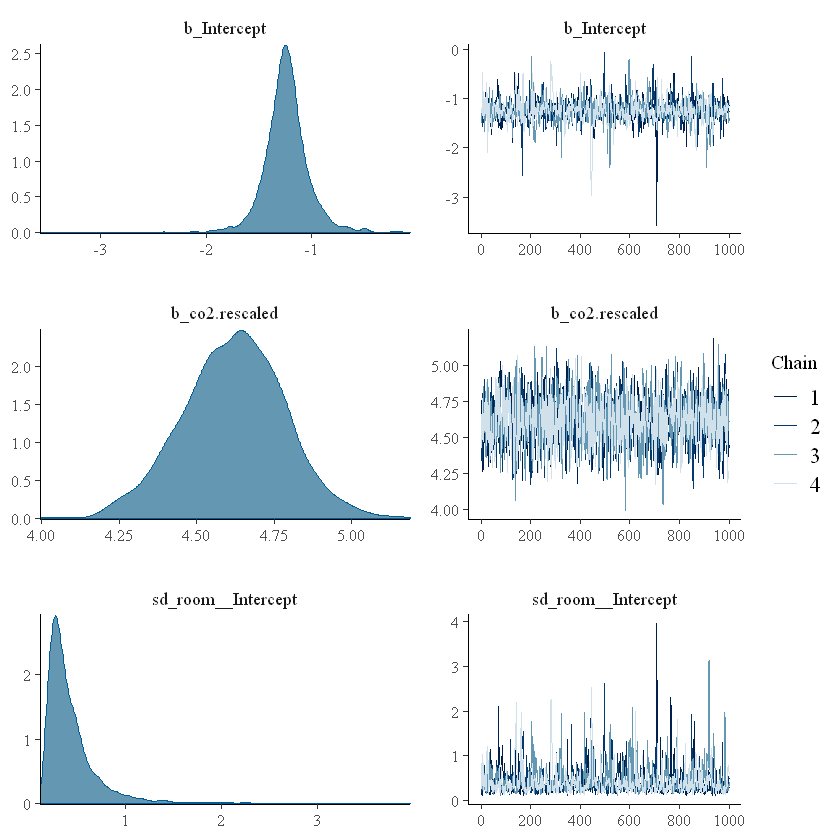

In [119]:
par(mfrow = 1:2, mar = c(5,3.8,1,0) + 0.1, las = 3)
plot(model_num_poiss, label_points = TRUE)

In [120]:
loo_model_num_negbinomial


Computed from 4000 by 1513 log-likelihood matrix

         Estimate   SE
elpd_loo  -1373.3 42.2
p_loo         6.2  0.5
looic      2746.7 84.4
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

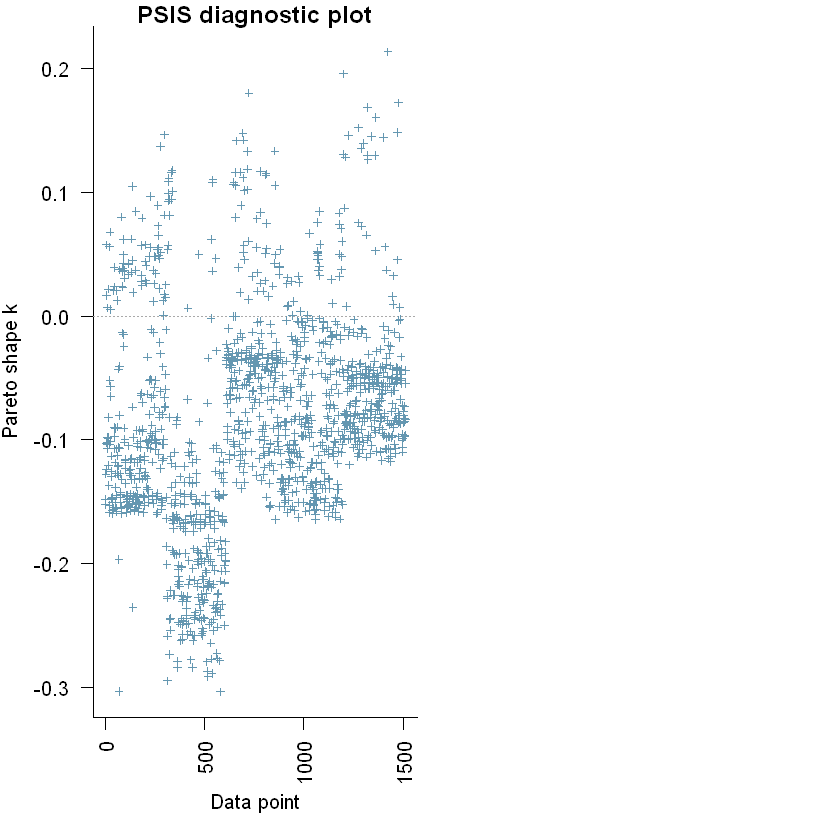

In [121]:
par(mfrow = 1:2, mar = c(5,3.8,1,0) + 0.1, las = 3)
plot(loo_model_num_negbinomial, label_points = TRUE)

In [122]:
loo_model_num_zero_inflated_poisson


Computed from 6000 by 1513 log-likelihood matrix

         Estimate   SE
elpd_loo  -1428.0 41.3
p_loo        10.7  3.2
looic      2855.9 82.6
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     1512  99.9%   797       
 (0.5, 0.7]   (ok)          1   0.1%   161       
   (0.7, 1]   (bad)         0   0.0%   <NA>      
   (1, Inf)   (very bad)    0   0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.